In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib

(800, 2) (800,)


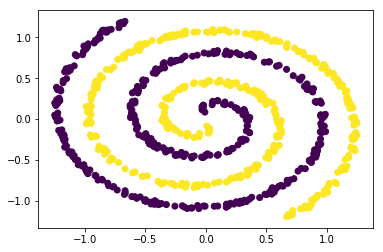

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.LongTensor(y)
print(x.shape, y.shape)
%matplotlib inline
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1))

In [38]:
## creating a probabilistic layer module
class ProbLayer(nn.Module):
    def __init__(self, in_features, out_features, n_probs=2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_probs = n_probs
        
        self.fcp = nn.Linear(in_features, n_probs*out_features)
        self.fcr = nn.Linear(in_features, n_probs*out_features)
        self.actf = lambda x:torch.exp(- x**2)
        
    def forward(self,x):
        p = self.actf(self.fcp(x))
        r = self.fcr(x)
        
        out = (p*r).reshape(-1,self.out_features, self.n_probs)
        out = out.sum(dim=-1)
        return out

## creating a RBF layer module
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, n_basis=2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_basis = n_basis
        
        self.actf = lambda x:torch.exp(- x**2)

        self.fcp = nn.Linear(in_features, n_basis)
        self.fcr = nn.Linear(n_basis, out_features, bias=True)

        ### This is done to adjust the parameters to ProbLayer type
#         self.fcp = nn.Linear(in_features, n_basis*out_features)
#         self.fcr = nn.Linear(n_basis*out_features, out_features, bias=True)

        self.fcr.weight.data *= 0
        
    def forward(self,x):
        p = self.actf(self.fcp(x))
        out = self.fcr(p)
        return out
    
#Modified RBF layer module
class SprobLayer(nn.Module):
    def __init__(self, in_features, out_features, n_probs=2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_probs = n_probs
        
        self.fcp = nn.Linear(in_features, n_probs*out_features)
        self.fcr = torch.nn.Parameter(torch.zeros(n_probs*out_features, dtype=torch.float32), requires_grad=True)
        self.register_parameter("Scaler",self.fcr)
#                 self.fcr = torch.FloatTensor(torch.from_numpy(np.random.uniform(low=-1,\
#                     high=1, size=[1,n_probs*out_features])))
    
        self.actf = lambda x:torch.exp(- x**2)
        
    def forward(self,x):
        p = self.actf(self.fcp(x))
        out = (p*self.fcr).reshape(-1,self.out_features, self.n_probs)
        out = out.sum(dim=-1)
        return out

In [39]:
## defining the model
class ProbClassification(nn.Module):
    
    def __init__(self, n_hidden=4):
        super().__init__()
        self.pl1 = ProbLayer(2,2, n_hidden)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self,x):
        out = self.pl1(x)
        out = self.softmax(out)
        return out


## defining the model
class RBFClassification(nn.Module):
    
    def __init__(self, n_hidden=4):
        super().__init__()
        self.rbf1 = RBFLayer(2,2, n_hidden)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self,x):
        out = self.rbf1(x)
        out = self.softmax(out)
        return out


    ## defining the model
class SprobClassification(nn.Module):
    
    def __init__(self, n_hidden=4):
        super().__init__()
        self.pl1 = SprobLayer(2,2, n_hidden)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self,x):
        out = self.pl1(x)
        out = self.softmax(out)
        return out

    
## defining the model
class MLPClassification(nn.Module):
    
    def __init__(self, n_hidden=4):
        super().__init__()
        self.fc1 = nn.Linear(2,n_hidden)
        self.actf = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, 2)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self,x):
        h = self.actf(self.fc1(x))
        out = self.fc2(h)
        out = self.softmax(out)
        return out
    
# model = ProbClassification(n_hidden=7)
model = RBFClassification(n_hidden=10)
# model = SprobClassification(n_hidden=10)
# model = MLPClassification(n_hidden=50)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
criterion = nn.CrossEntropyLoss()

In [40]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.ion()
fig.show()
fig.canvas.draw()

EPOCHS = 100000
for step in range(EPOCHS):

    yout = model(xx)
#     print(yout.shape, yy.shape)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:

        print('_______________________')
        print("epoch", step)
        print("Loss", loss.data)
        
        out = torch.argmax(yout, dim=1)

        ax.clear()
        plt.scatter(x[:,0], x[:, 1], c=out.data.numpy().reshape(-1))       
        fig.canvas.draw()
        plt.pause(0.01)
        print()
        if loss < 0.001:
            print('fitted to our expectation')
            break

_______________________
epoch 0
Loss tensor(0.6937)

_______________________
epoch 100
Loss tensor(0.6475)

_______________________
epoch 200
Loss tensor(0.6437)

_______________________
epoch 300
Loss tensor(0.6431)

_______________________
epoch 400
Loss tensor(0.6429)

_______________________
epoch 500
Loss tensor(0.6426)

_______________________
epoch 600
Loss tensor(0.6423)

_______________________
epoch 700
Loss tensor(0.6418)

_______________________
epoch 800
Loss tensor(0.6410)

_______________________
epoch 900
Loss tensor(0.6402)

_______________________
epoch 1000
Loss tensor(0.6371)

_______________________
epoch 1100
Loss tensor(0.6262)

_______________________
epoch 1200
Loss tensor(0.6143)

_______________________
epoch 1300
Loss tensor(0.5963)

_______________________
epoch 1400
Loss tensor(0.5712)

_______________________
epoch 1500
Loss tensor(0.5482)

_______________________
epoch 1600
Loss tensor(0.5306)

_______________________
epoch 1700
Loss tensor(0.5185)

____

TclError: invalid command name "pyimage159"

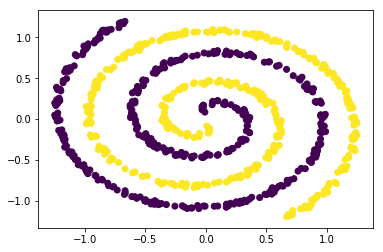

In [32]:
%matplotlib inline
plt.scatter(x[:,0], x[:, 1], c=out.data.numpy().reshape(-1)) 

In [33]:
# ##### For probabilistic network only
# p = model.pl1.actf(model.pl1.fcp(xx))
# r = model.pl1.fcr(xx)
# out = model(xx)

# plt.scatter(x[:,0], x[:, 1], c=yout.data.numpy().reshape(-1)) 
# for prb in p.data.numpy().T:
#     plt.scatter(x[:,0], prb, marker='.', c='y')

In [34]:
# ##### For RBF network only
# p = model.pl1.actf(model.rbf1.fcp(xx))
# plt.scatter(x[:,0], x[:, 1], c=out.data.numpy().reshape(-1)) 
# for prb in p.data.numpy().T:
#     plt.scatter(x[:,0], prb, marker='.', c='y')
# # plt.scatter(x[:,0], p[:,1].data.numpy(), marker='.', c='y')

In [35]:
# p.shape

In [36]:
##### What does each units represent/classify/cover ??

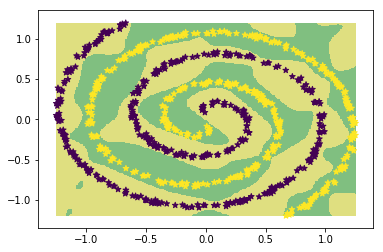

In [37]:
h = 0.01
x_, y_ = np.meshgrid(np.arange(x[:,0].min(), x[:,0].max(), h), np.arange(x[:,1].min(), x[:,1].max(), h))
xx_img = np.c_[x_.ravel(), y_.ravel()]
xx_img = torch.FloatTensor(xx_img)
yout_img = model(xx_img)
out = yout_img.data.numpy()
out = (out.argmax(axis=1)).astype(int)

colors = ['r', 'y', 'g', 'b']
plt.imshow(out.reshape(x_.shape), interpolation='nearest',
           extent=(x_.min(), x_.max(), y_.min(), y_.max()),
           cmap=matplotlib.colors.ListedColormap(colors[1:-1]),
           alpha=0.5,
           aspect='auto', origin='lower')

plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')

In [185]:
model.parameters

<bound method Module.parameters of SprobClassification(
  (pl1): SprobLayer(
    (fcp): Linear(in_features=2, out_features=20, bias=True)
  )
  (softmax): Softmax()
)>